- Extract cross-spectra (for each consequent pair of frames)
- Average cross-spectra derived from each pair
- Plot directional frequency spectra

In [1]:
import os
import glob
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift, ifft2, fftfreq
from scipy.signal import medfilt
from scipy.interpolate import RectBivariateSpline
from scipy.signal import welch

In [2]:
dir_in = 'DJI_0398/projections'

config = 'band0_sub5_res1_cubic_kernel40_dt1s'

name_in = f'frame_{config}'

time_step = 1 # seconds

ground_spacing = 1 # meters

dir_out = os.path.join('/'.join(os.path.split(dir_in)[:-1]), 'diags')

name_out = f'diag_{config}'

if not os.path.exists(dir_out):
    os.makedirs(dir_out)


## Read input files

In [3]:
# input files
files_in = sorted(glob.glob(f'{dir_in}/{name_in}*.nc'))

In [4]:
# Stack all nc files in 3d array [time, y, x]
for i in range(len(files_in)):
    ds = nc.Dataset(files_in[i])
    if i==0:
        data = ds.variables['data'][:]
    else:
        data = np.append(data,ds.variables['data'][:],axis=0)
    ds.close()

In [5]:
# Reverse azimuth axis to stick to the orientation of initial frames
data = data[:,::-1,:]


In [6]:
data.shape

(61, 382, 950)

## Wavenumber cross-spectra

In [7]:
def rebin(a, shape):
    
    sh = shape[0], a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    
    return a.reshape(sh).mean(-1).mean(1)

def looks2xspec(im1, im2, periodo_size):
    """
    Derive cross-spectra from a pair of frames.
    
    :param im1:
    :param im2:
    :param periodo_size:
    :returns specs:
    """
    
    imshape = np.array(im1.shape, dtype='int32')

    ###########################################################################
    # Set periodograms/looks/specs sizes and positions
    ###########################################################################

    # Define Hanning window in azimuth and range
    aziwindow = np.hanning(periodo_size + 2)[1:-1]
    ranwindow = np.hanning(periodo_size + 2)[1:-1]
    # Two dimensional window as a root of product of range and azimuth hanning windows 
    window = np.sqrt(np.outer(aziwindow, ranwindow))
    
    ###########################################################################
    # Compute periodograms and compute co/cross spectra
    ###########################################################################
    
    # Compute number of periodograms in the image 
    count = np.ceil(imshape[0]/periodo_size).astype('int32')
    # Positions of a periodogram in azimuth and range direction
    perpos = (np.floor(np.linspace(0, imshape[0]-periodo_size, num=count)+0.5).astype('int32'),
              np.floor(np.linspace(0, imshape[1]-periodo_size, num=count)+0.5).astype('int32'))
    # Define shape of the spectra
    specshape = np.array((periodo_size, periodo_size), dtype='int32')
    # Create empty spectra (filled zeros) with shape <specshape>
    specs = np.zeros(specshape, dtype='complex64')
    # For each periodogram in the image
    for appos in iter(perpos[0]):
        for rppos in iter(perpos[1]):
            per1 = fft_periodogram(im1, appos, rppos, periodo_size, window)
            per2 = fft_periodogram(im2, appos, rppos, periodo_size, window)
            specs += per1 * np.conj(per2)

    return specs

def fft_periodogram(image, az_pos, range_pos, periodo_size, window):
    # Subset periodogram from the image 1
    subset = image[az_pos:az_pos + periodo_size, range_pos:range_pos + periodo_size]
    # Remove mean
    subset = subset - np.mean(subset)
    # Calculate FFT for the preiodogram
    per = fftshift(fft2(subset * window))/periodo_size
    return per

In [8]:
spec = []

for i in range(data.shape[0]-1):

    data1 = data[i]
    data2 = data[i+1]
    
    # Croping
    Ny, Nx = 1, 1
    while 2*Ny<data1.shape[0]:
        Ny *= 2
    while 2*Nx<data1.shape[1]:
        Nx *= 2
    data1 = data1[int(data1.shape[0]//2 - Ny//2): int(data1.shape[0]//2 + Ny//2),
                  int(data1.shape[1]//2 - Nx//2): int(data1.shape[1]//2 + Nx//2)]
    data2 = data2[int(data2.shape[0]//2 - Ny//2): int(data2.shape[0]//2 + Ny//2),
                  int(data2.shape[1]//2 - Nx//2): int(data2.shape[1]//2 + Nx//2)]

    _spec = looks2xspec(data1, data2, min(Nx,Ny))
    spec.append(_spec)
    
spec = np.asarray(spec).sum(axis=0)/len(spec)

In [9]:
print(f'{data.shape[1:]} --> ({Ny},{Nx})')

(382, 950) --> (256,512)


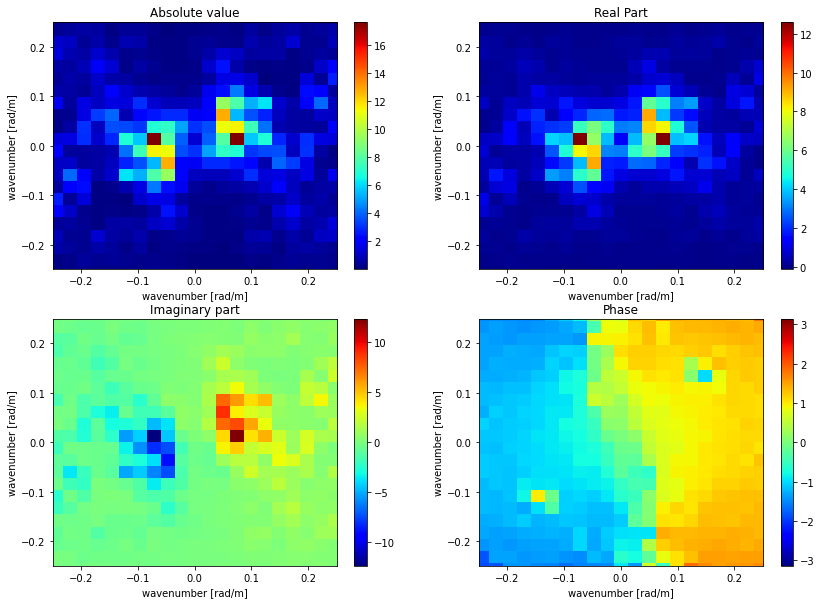

In [10]:
periodo_size = min(Nx,Ny)

xlim = (-.25,.25)
ylim = (-.25,.25)

kran = (np.arange(periodo_size)-periodo_size/2.)/periodo_size*2*np.pi/ground_spacing
kazi = (np.arange(periodo_size)-periodo_size/2.)/periodo_size*2*np.pi/ground_spacing


fig = plt.figure(figsize = (14,10))

plt.subplot(2, 2, 1)
plt.imshow(np.abs(spec), extent=[kran[0], kran[-1],
            kazi[-1], kazi[1]], aspect='auto',cmap='jet')
plt.xlabel('wavenumber [rad/m]')
plt.ylabel('wavenumber [rad/m]')
plt.title('Absolute value')
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(np.real(spec), extent=[kran[0], kran[-1],
            kazi[-1], kazi[1]],aspect='auto',cmap='jet')
plt.xlabel('wavenumber [rad/m]')
plt.ylabel('wavenumber [rad/m]')
plt.title('Real Part')
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(np.imag(spec), extent=[kran[0], kran[-1],
            kazi[-1], kazi[1]],aspect='auto',cmap='jet')
plt.xlabel('wavenumber [rad/m]')
plt.ylabel('wavenumber [rad/m]')
plt.title('Imaginary part')
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(np.angle(spec), extent=[kran[0], kran[-1],
           kazi[-1], kazi[1]],aspect='auto',cmap='jet')
plt.xlabel('wavenumber [rad/m]')
plt.ylabel('wavenumber [rad/m]')
plt.title('Phase')
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar()

plt.savefig(f'{dir_out}/{name_out}_cross-spectra.png')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


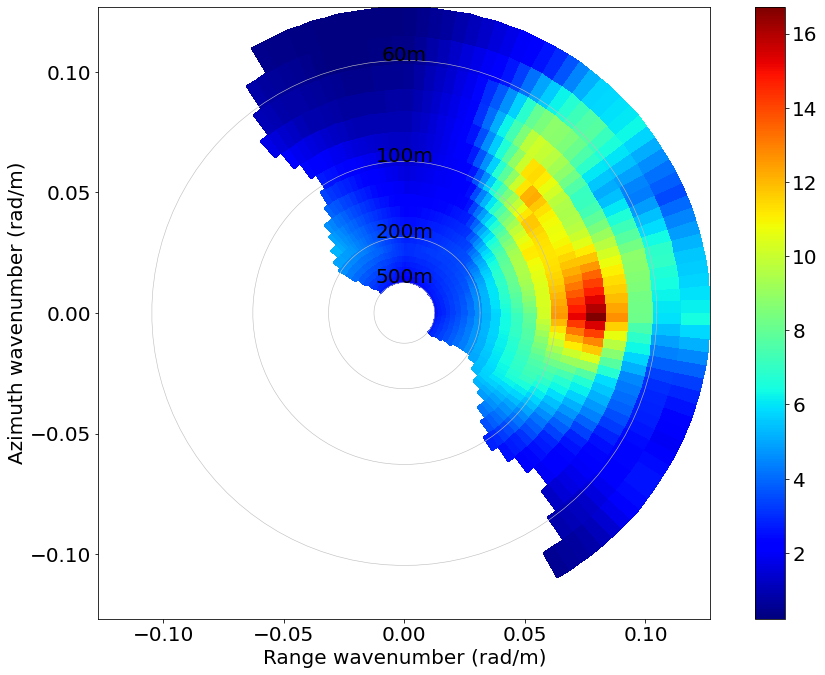

In [29]:
def cart2logpol(spec, kazi, kran, nphi=72, nk=60, kmin=2.*np.pi/500,
                kmax=2.*np.pi/1, heading=None):
    """
    """
    # Define log-polar grid
    phi = np.linspace(0., 360., num=nphi, endpoint=False)
    dphi = phi[1] - phi[0]
    alpha = (kmax / kmin) ** (1. / (nk - 1.))
    k = kmin * alpha ** np.arange(nk)
    dk = (np.sqrt(alpha) - 1. / np.sqrt(alpha)) * k
    # Bilinear interpolation
    intfunc = RectBivariateSpline(kazi, kran, spec, kx=1, ky=1)
    if heading is None:
        # phi clockwise, phi=0 means up azimuth
        angincart = np.deg2rad(90. - phi)
    else:
        angincart = np.deg2rad(90. - (phi - heading))
    intkazi = k[np.newaxis, :] * np.sin(angincart[:, np.newaxis])
    intkran = k[np.newaxis, :] * np.cos(angincart[:, np.newaxis])
    polspec = np.zeros((nphi, nk), dtype=spec.dtype)
    indint = np.where((intkazi >= kazi[0]) & (intkazi <= kazi[-1]) & (intkran >= kran[0]) & (intkran <= kran[-1]))
    polspec[indint] = intfunc(intkazi[indint], intkran[indint], grid=False)
    # Energy conservation
    dkazi = kazi[1] - kazi[0]
    dkran = kran[1] - kran[0]
    kcart = np.sqrt(kazi[:, np.newaxis] ** 2. + kran[np.newaxis, :] ** 2.)
    indcart = np.where((kcart >= kmin) & (kcart <= kmax))
    enecart = 4. * np.sqrt(np.nansum(np.abs(spec[indcart])) * dkazi * dkran)
    areapol = k * dk * np.deg2rad(dphi)
    enepol = 4. * np.sqrt(np.nansum(np.abs(polspec) * areapol[np.newaxis, :]))
    polspec *= (enecart / enepol) ** 2.

    return polspec, phi, dphi, k, dk

#
lmin = 50

# Spectra
polspec, phi, dphi, ks, dk = cart2logpol(np.abs(spec), kazi, kran,nphi=72*2)

# Phase
polphase, phi, dphi, ks, dk = cart2logpol(np.angle(spec), kazi, kran,nphi=72*2)

# Remove pixels with low energies or with negative phase
threshold = .0
indNaN = (polspec<threshold*polspec.max()) | (polphase<0)
polspec[indNaN] = np.nan
polphase[indNaN] = np.nan

# Polar coordinates
_pl = phi + dphi / 2.#np.concatenate(([phi[0] - dphi / 2.], phi[:-1] + dphi / 2., [phi[-1] + dphi / 2.]))
_pl = np.deg2rad(90. - _pl)
indk = np.where((ks <= 2. * np.pi / lmin))[0]
k = ks[indk] + dk[indk] / 2.
_kl = +k#np.concatenate(([0], k))
_xl = _kl[np.newaxis, :] * np.cos(_pl[:, np.newaxis])
_yl = _kl[np.newaxis, :] * np.sin(_pl[:, np.newaxis])


fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(left=0.15, right=0.975, bottom=0.1, top=0.95, wspace=0.145)
plt.pcolormesh(_xl, _yl, polspec[:, indk], cmap=plt.get_cmap('jet'))#, vmin=vmin, vmax=vmax)

# Iso-angles
cirx = np.cos(np.linspace(0, 2. * np.pi, num=100))
ciry = np.sin(np.linspace(0, 2. * np.pi, num=100))
for wl in [500, 200, 100, 60]:
    plt.plot(2. * np.pi / wl * cirx, 2. * np.pi / wl * ciry,color='silver',linewidth=0.6 )
    plt.text(0, 2. * np.pi / wl,'{:d}m'.format(wl),color='k',horizontalalignment='center', fontsize=20)


plt.xlabel('Range wavenumber (rad/m)', fontsize=20)
plt.ylabel('Azimuth wavenumber (rad/m)', fontsize=20)
plt.gca().set_aspect('equal')
cbar = plt.colorbar()

# change colorbar fontsize
tick_font_size = 20
cbar.ax.tick_params(labelsize=tick_font_size)

# changing the fontsize of yticks
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()

fig.savefig(f'{dir_out}/{name_out}_polar-cross-spectra.png')

## Phase velocity

In [31]:
k = np.sqrt(_xl**2+_yl**2)
vphase_obs = polphase[:, indk] / k / time_step
vphase_theory = np.sqrt(9.81/k)
vphase_theory[indNaN[:, indk]] = np.nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  # Remove the CWD from sys.path while we load stuff.


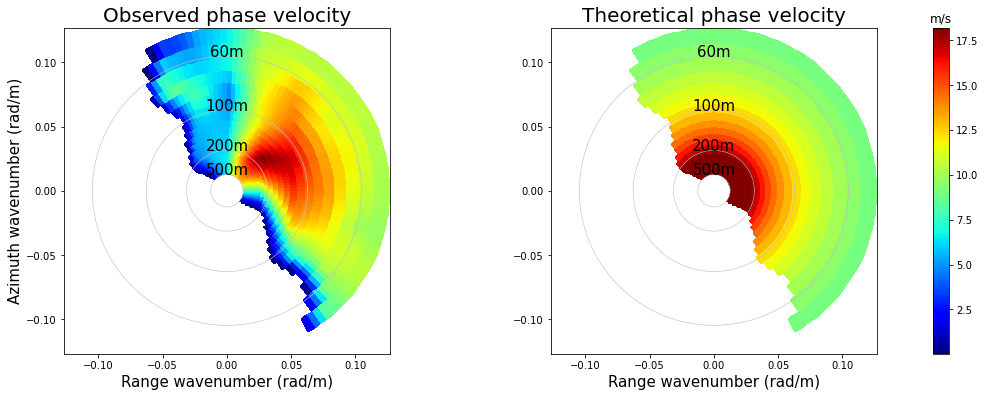

In [32]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))

ax1.set_title('Observed phase velocity', fontsize=20)
ax2.set_title('Theoretical phase velocity', fontsize=20)

vmin = np.nanmin(vphase_obs)
vmax = np.nanmax(vphase_obs)

im = ax1.pcolormesh(_xl, _yl, vphase_obs[:, indk], cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)
ax2.pcolormesh(_xl, _yl, vphase_theory[:, indk], cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)

# Iso-angles
for ax in [ax1,ax2]:
    for wl in [500, 200, 100, 60]:
        ax.plot(2. * np.pi / wl * cirx, 2. * np.pi / wl * ciry,color='silver',linewidth=0.6 )
        ax.text(0, 2. * np.pi / wl,'{:d}m'.format(wl),color='k',horizontalalignment='center', fontsize=15)


    ax.set_xlabel('Range wavenumber (rad/m)', fontsize=15)
    ax.set_aspect('equal')
ax1.set_ylabel('Azimuth wavenumber (rad/m)', fontsize=15)
    
cbar = plt.colorbar(im,ax=(ax1,ax2))
cbar.ax.set_title('m/s')

plt.savefig(f'{dir_out}/{name_out}_2d-phase-velocity.png')

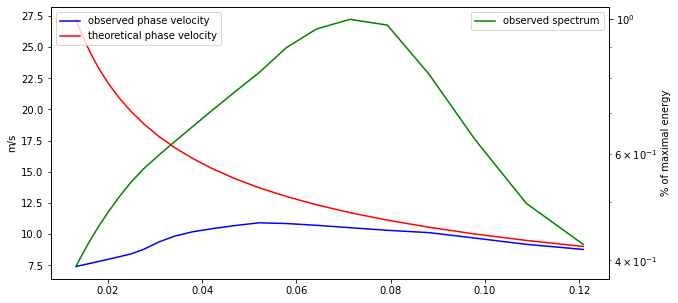

In [33]:
fig,ax = plt.subplots(1,1,figsize = (10,5))

mini = int(periodo_size/2+5)
sp = np.nanmean(np.real(polspec[:, indk]), axis=0)
ax.plot(k[0],np.nanmean(vphase_obs,axis=0), 'b', label='observed phase velocity')
ax.plot(k[0],np.nanmean(vphase_theory,axis=0), 'r', label='theoretical phase velocity')
ax.legend(loc=2)
ax.set_ylabel('m/s')

ax2 = ax.twinx()
ax2.semilogy(k[0],sp/np.nanmax(sp), 'g', label='observed spectrum')
ax2.legend()
ax2.set_ylabel('% of maximal energy')

plt.xlabel('wavenumber')
#plt.ylim(0.01,.12)
plt.savefig(f'{dir_out}/{name_out}_1d-phase-velocity.png')

## Frequency spectra

In [34]:
psd = 0

for i in range(data.shape[1]):
    for j in range(data.shape[2]):     
        f, _psd = welch(data[:,i,j], 1/time_step, nperseg=32)
        psd += _psd/data.shape[1]/data.shape[2]

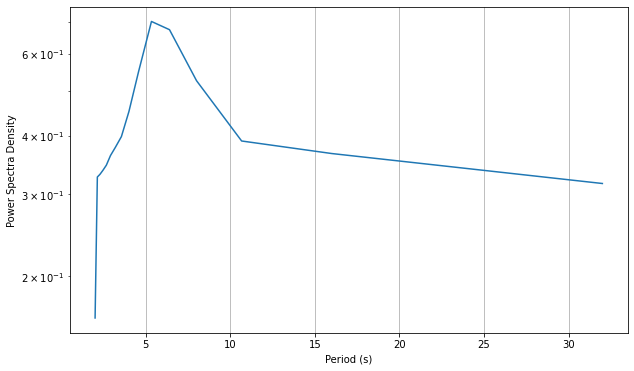

In [35]:
fig = plt.figure(figsize = (10,6))
plt.semilogy(1/f[1:], psd[1:])
# plt.xlim(0,30)
plt.xlabel('Period (s)')
plt.ylabel('Power Spectra Density')
plt.grid()
plt.savefig(f'{dir_out}/{name_out}_freq-spectra.png')